In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 2 nodes:
0:[1]
1:[0]

Nodes: [0, 1]
Edges: [(0, 1)]


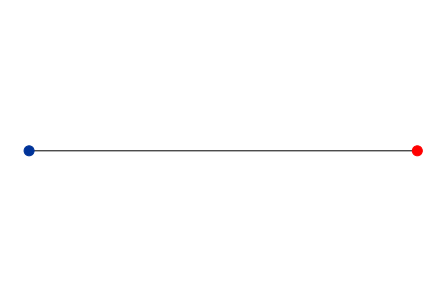

In [23]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}
        
    def add_node(self, node, val=0):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        # Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return # This edge doesn't exist, done
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
        
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1,0,0)
        BLUE = (0,0.2,0.6)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]]==0:
                colors.append(BLUE)
            else:
                colors.append(RED)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
        #nx.draw_spring(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = 1
g.plot()

In [24]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

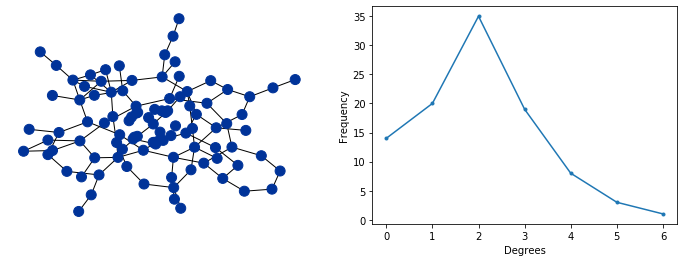

In [25]:
def random_network(n_nodes=7):
    """creates random network (Erdos type II)"""
    n_edges = n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g
    
g = random_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

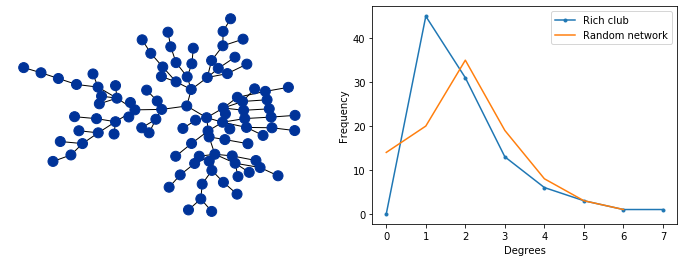

In [26]:
def rich_club_network(n_nodes=7):
    """Alternative network creator"""
    g = Graph()
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        else:
            g.add_edge(i, np.random.randint(low=0, high=i))
    return g

g = rich_club_network(100)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g)
plt.plot(degrees_random);
plt.legend(['Rich club','Random network']);

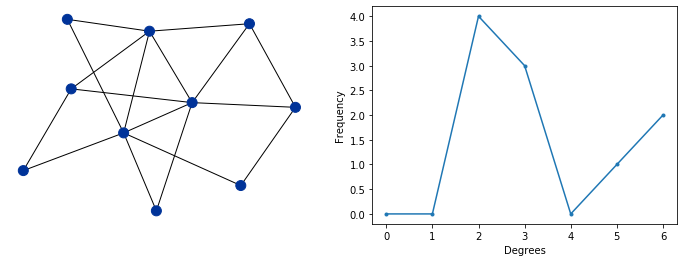

In [40]:
def barabasi(n_nodes=7):
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        elif i==1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else: # Actual preferential attachment
            connections = np.random.choice(nodes[:i], size=2, replace=False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
    return g

g = barabasi(10)
plt.figure(figsize=(12,4))
plt.subplot(121)
g.plot();
plt.subplot(122)
degrees(g);


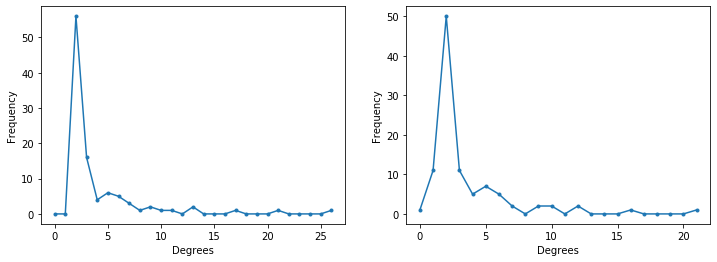

In [29]:
def remove_hub(g):
    """Isolate the most connected node"""
    highest_so_far = 0
    best_node = None
    for node,links in g.gdict.items():
        if len(links)>highest_so_far:
            highest_so_far = len(links)
            best_node = node
    #print(best_node, g.gdict[best_node])
    for node in g.gdict[best_node].copy():
        g.delete_edge(best_node, node)

# Test
g = barabasi(100)
plt.figure(figsize=(12,4))
plt.subplot(121);
degrees(g);
remove_hub(g)
plt.subplot(122);
degrees(g);

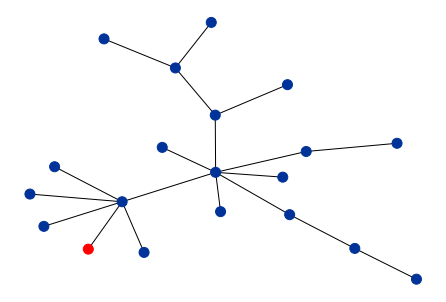

In [10]:
def pandemic(g, prob = 0.5,nsteps =10):
    nodes = g.get_nodes()
    for node in nodes:
        g.values[node] = 0
    patient_zero = np.random.randint(low=0, high=len(nodes))
    g.values[patient_zero] = 1

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        for node in g.get_nodes():
            if g.values[node]==1:
                neighbors = g.gdict[node]
                for neighbor in neighbors:
                    if g.values[neighbor] ==0 and np.random.uniform()< prob:
                        newly_infected.append(neighbor)
        for node in newly_infected:
            g.values[node]=1
        history[t] = len(newly_infected)
    return history

#test
g = rich_club_network(20)
history = pandemic(g,prob = 0.1, nsteps=1)
g.plot()


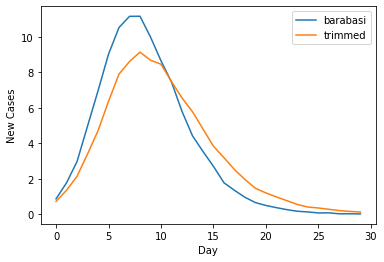

In [43]:
n_steps=30
n_trials = 500
prob_2 = 0.2

history =np.zeros(shape=(n_steps,n_trials*2))
for i in range(n_trials):
    g = barabasi(100)
    history[:,i] = pandemic(g,prob = prob_2, nsteps=n_steps)
    remove_hub(g)
    history[:,i+n_trials] = pandemic(g,prob = prob_2, nsteps=n_steps)

plt.plot(np.mean(history[:, :n_trials], axis=1), label='barabasi');
plt.plot(np.mean(history[:, n_trials:], axis=1), label='trimmed');
plt.xlabel("Day");
plt.ylabel("New Cases");
plt.legend(loc='upper right');